In [32]:
import calls_finder as cf
from annotations import Annotations

import copy
from multiprocessing import pool
import time
import os
import librosa
import numpy as np
from birdnetlib import analyzer, Recording
import operator
from scipy import signal,ndimage
from annotations import Annotations, SegmentsWrapper
from segment import Segment, ConfidenceFreqSegment
from intervaltree import IntervalTree
from units import TimeUnit
from copy import deepcopy
from table_writers import RavenWriter
from loggers import Logger
import matplotlib.pyplot as plt

"105_Sauge_Recorder/20230623_190000" 
"seg 20"


'seg 20'

In [33]:

dur_birdnet = 3
subseg_dur = .75
margin = .2
min_dur = .5
conf_thresh = .1
random_seed = 42

In [34]:

annotations = Annotations(r"C:\Users\plaf\Music\ALAN_training\bug", "bnrv")
annotations.load()
annotations.load_audio_paths("c:\\Users\\plaf\\Music\\ALAN_training\\bug") 
af_wrap = list(annotations.audio_files.values())[0]
classifier_model_path =  r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier.tflite"
an = cf.analyzer.Analyzer(classifier_model_path=classifier_model_path,
                        classifier_labels_path=cf.get_label_path(classifier_model_path))  
print(af_wrap.audio_file.path)


Reading tables: [--------------------------------------->] 100%
Retrieving audio paths: [--------------------------------------->] 100%
load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
c:\Users\plaf\Music\ALAN_training\bug\20230623_190000.WAV


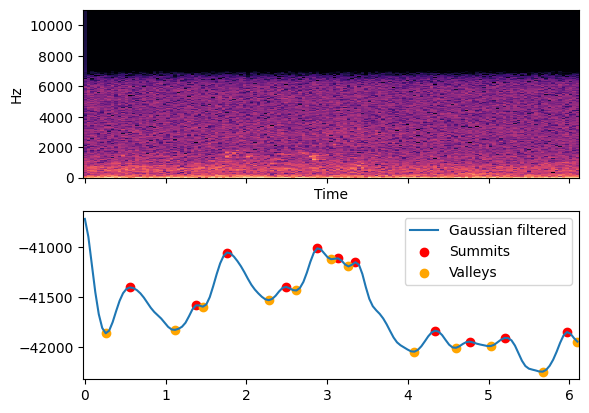

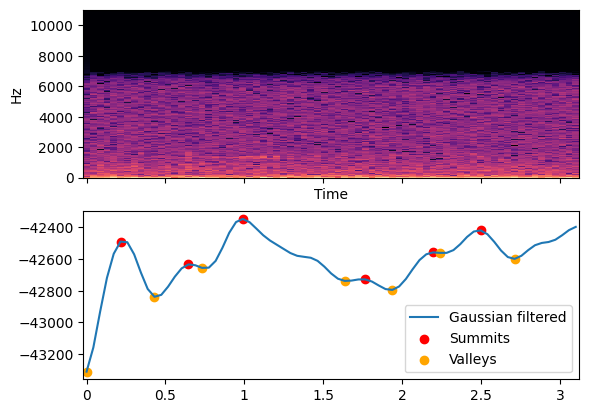

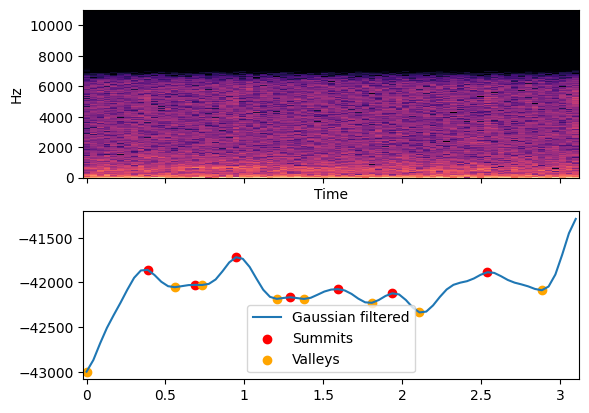

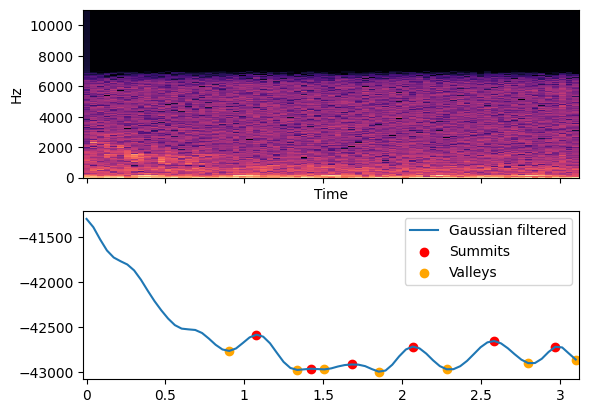

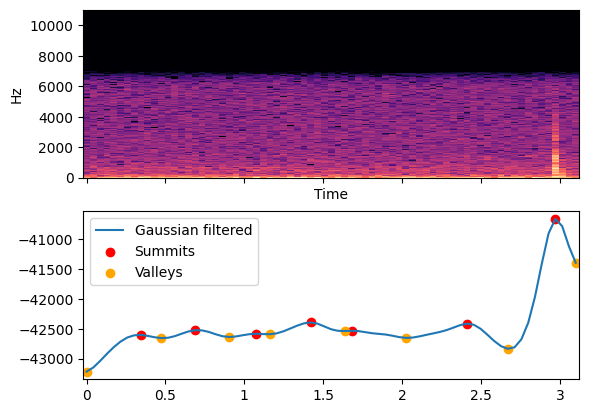

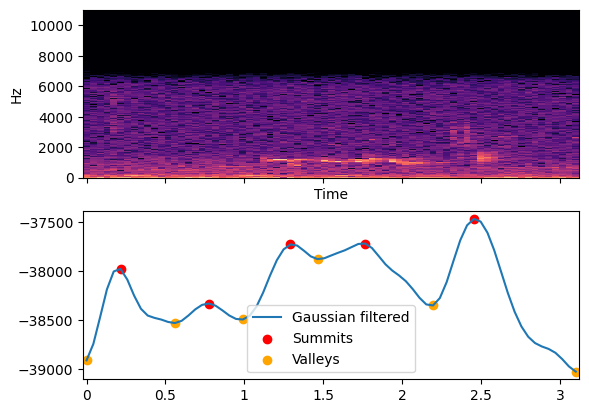

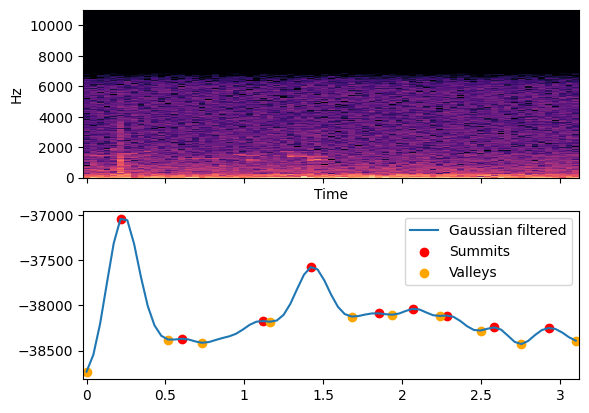

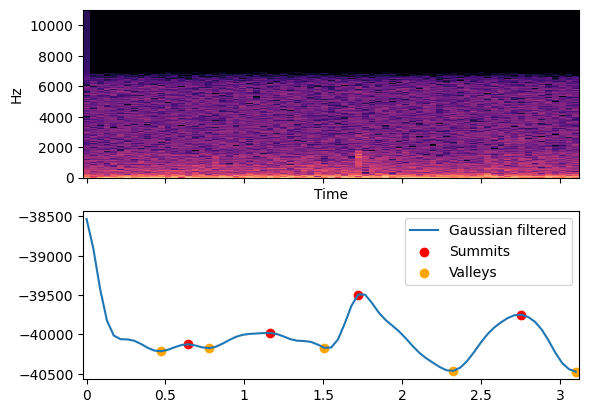

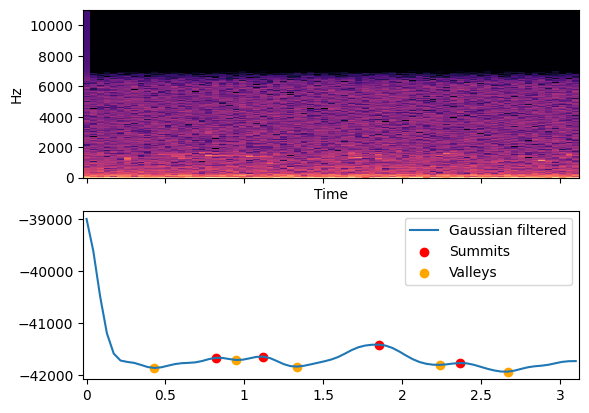

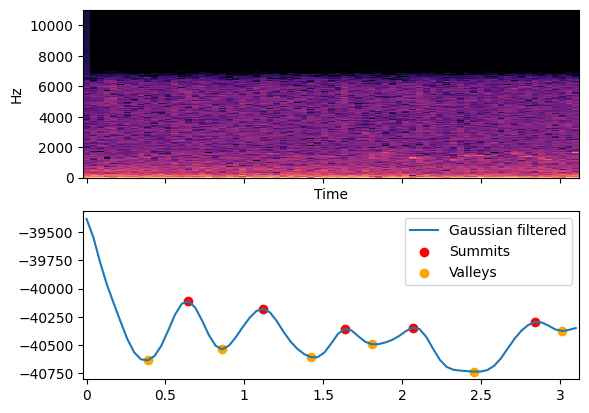

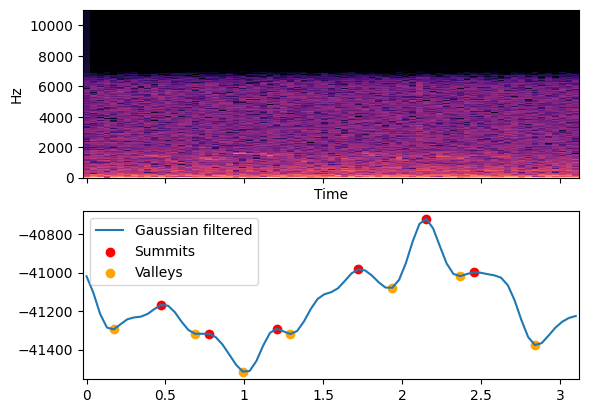

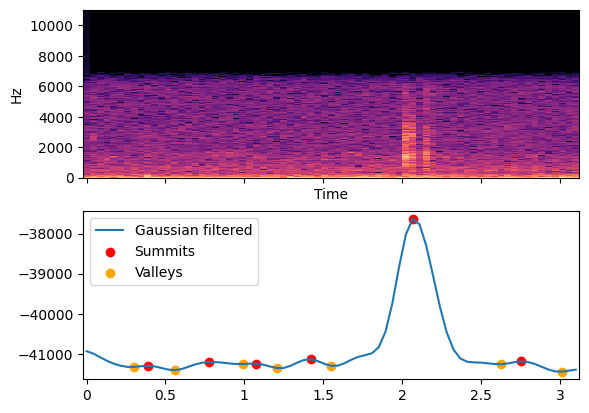

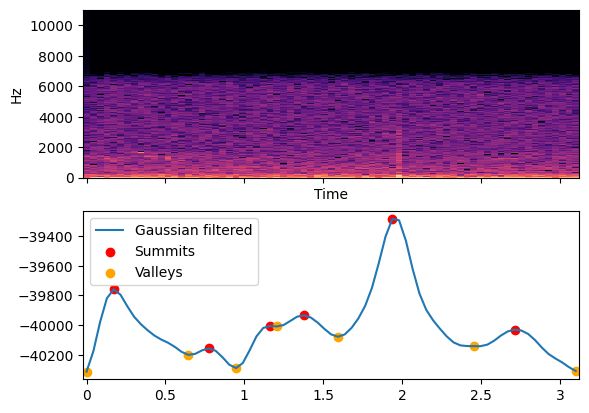

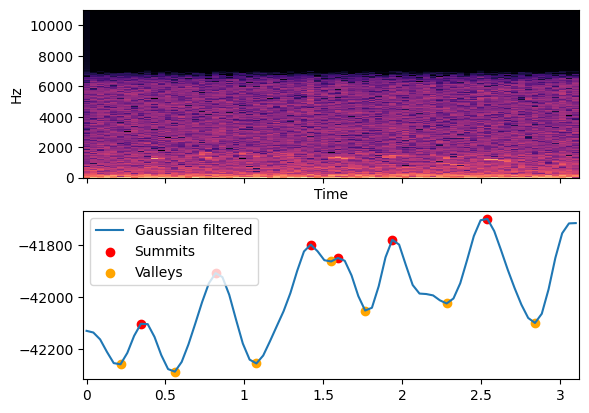

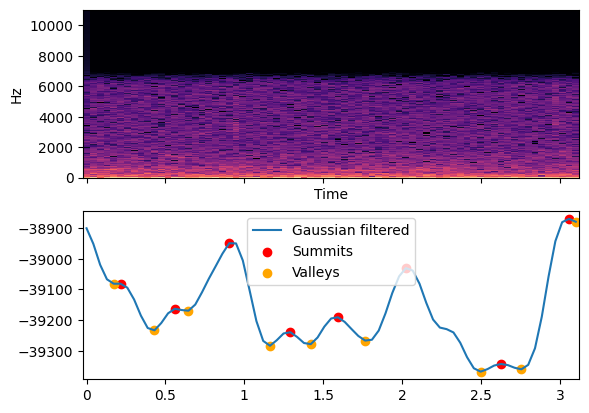

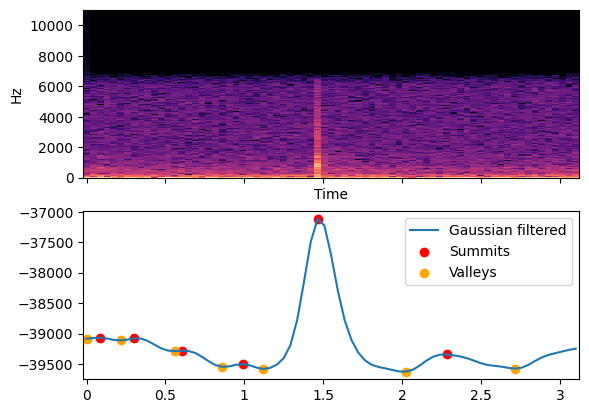

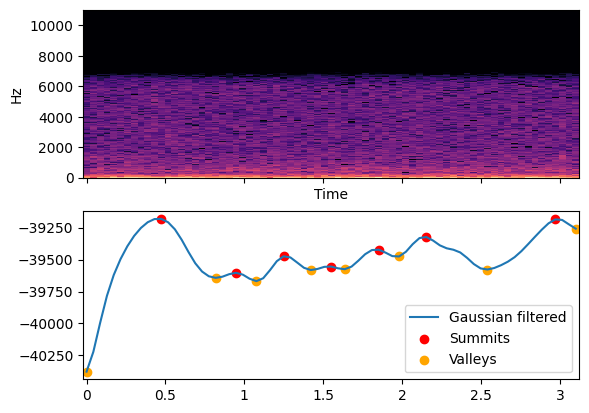

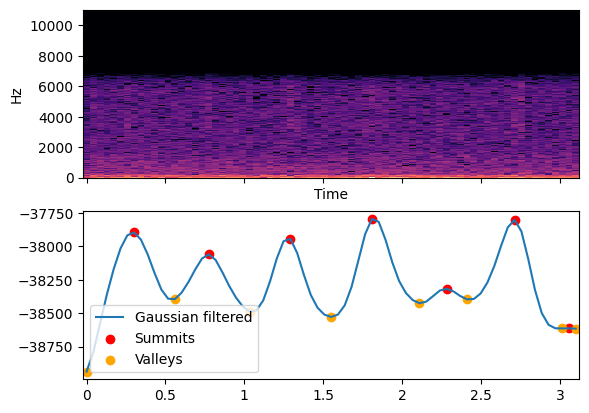

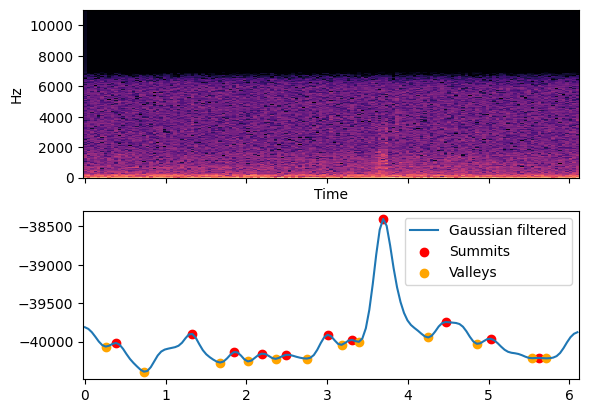

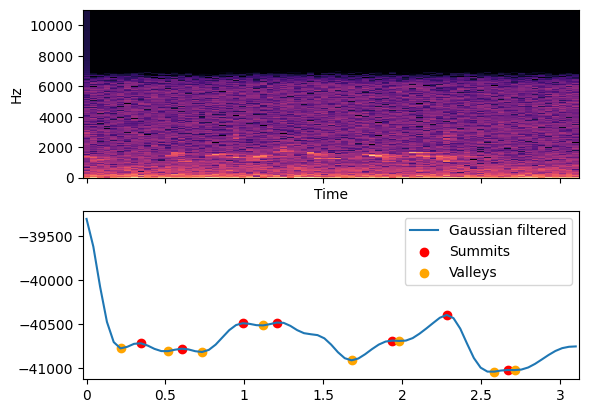

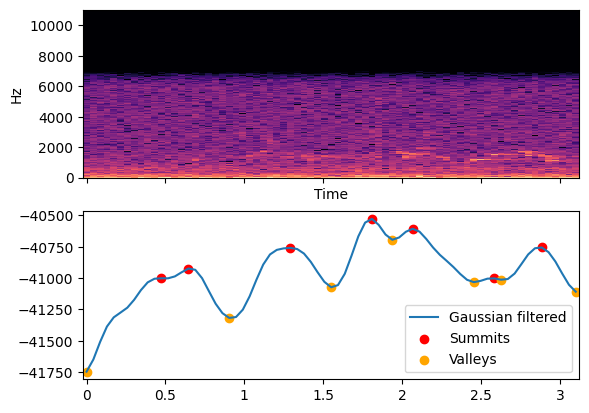

ValueError: operands could not be broadcast together with shapes (7,) (6,) 

In [38]:

af = af_wrap.audio_file
segments_original = af_wrap.segments_interval_tree

# Little trick to make the segments actually overlap:
segments = [Segment(max(0, s.tstart - .1), s.tend, s.label) for s in af_wrap.segments]
segments: IntervalTree = Segment.get_intervaltree(segments)
segments.merge_overlaps()

segments = sorted(segments, key = lambda s: s.begin)
calls  = []



for i, seg in enumerate(segments[20:]):
    if not isinstance(seg, Segment):
        seg = Segment(tstart_s=seg.begin, tend_s=seg.end, label=seg.data)
            

    tstart = seg.tstart
    dur = seg.dur

    y, sr = librosa.load(af.path, sr=48000, mono=True, res_type="kaiser_fast", offset = tstart, duration=dur)
    sample_dur_birdnet = int(dur_birdnet * sr)

    n_fft = 2048
    hop_length = n_fft
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spec = librosa.amplitude_to_db(np.abs(S))
    spec_sum = np.sum(spec, axis=0)
    conv = ndimage.gaussian_filter1d(spec_sum, 2)

    summit = np.zeros_like(conv, dtype=np.bool_)

    summit[1:-1] = (conv[:-2] <= conv[1:-1]) & (conv[1:-1] >= conv[2:])
    # Force the existance of only one point in the neighborhood:
    summit[1:] &= ~summit[:-1] 

    if not np.any(summit):
        # In case of no local maxima (really rare), add whole interval
        mean_conf = np.mean([s.confidence if isinstance(s, ConfidenceFreqSegment) else 1  for s in segments_original[tstart.s: (tstart+dur).s]])
        calls.append(ConfidenceFreqSegment(seg.tstart, seg.tend, seg.label, confidence=round(mean_conf, 4)))
        continue

    summit_i = np.flatnonzero(summit)





    valley = np.zeros_like(summit)
    valley[1:-1] = (conv[:-2] >= conv[1:-1]) & (conv[1:-1] <= conv[2:])
    # Force the existance of only one point in the neighborhood:
    valley[1:] &= ~valley[:-1] 
    valley_i = np.flatnonzero(valley)



    valley[0] = len(valley_i) == 0 or summit_i[0] < valley_i[0]
    valley[-1] = len(valley_i) == 0 or summit_i[-1] > valley_i[-1]

    tstamps_arr = lambda arr: np.linspace(0, dur, len(arr))
    plot_vals = lambda arr: (tstamps_arr(arr), arr)
    spec_tstamps = tstamps_arr(spec.T)

    fig, ax = plt.subplots(nrows=2, sharex=True)
    librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
    ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
    ax[1].scatter(tstamps_arr(conv)[summit], conv[summit], c="red", label="Summits")
    ax[1].scatter(tstamps_arr(conv)[valley], conv[valley], c="orange", label="Valleys")
    ax[1].legend()
    plt.show()
    plt.close()

    valley_i = np.flatnonzero(valley)


    previous_valley = conv[valley_i[:-1]]
    next_valley = conv[valley_i[1:]]
    d = np.stack([previous_valley, next_valley])

    # Normalize the summits by subtracting the mean of the left and right closest valleys
    spikes = conv[summit] - np.mean(d, axis=0)


    dconv = np.diff(conv)

    thresh = np.mean(spikes)
    sample_start_mask = np.zeros_like(y, dtype=np.bool_)
    sample_start_mask[valley_i[:-1][spikes > thresh]] = True
    sample_start_i = np.flatnonzero(sample_start_mask)
    sample_end_mask = np.zeros_like(sample_start_mask)
    sample_end_mask[valley_i[1:][spikes > thresh]] = True
    sample_end_i = np.flatnonzero(sample_end_mask)
    for i, (ssi, sei) in enumerate(zip(sample_start_i, sample_end_i)):
        dconv_ = dconv[ssi:sei]
        sample_start_i[i] = ssi + np.argmax(dconv_)
        sample_end_i[i] = ssi + np.argmin(dconv_)


    px_to_sample = len(y) / len(conv)
    subseg_starts = ((sample_start_i) * px_to_sample - margin * sr).astype(np.int64)
    subseg_ends =  ((sample_end_i) * px_to_sample + margin * sr).astype(np.int64)

    if len(subseg_starts) == 0 or len(subseg_ends) == 0:
        mean_conf = np.mean([s.confidence if isinstance(s, ConfidenceFreqSegment) else 1 for s in segments_original[tstart.s: (tstart+dur).s]])
        calls.append(ConfidenceFreqSegment(seg.tstart, seg.tend, seg.label, confidence=round(mean_conf, 4)))
        continue


    noise = [y[:subseg_starts[0]]]
    for ss, se in zip(subseg_starts[1:], subseg_ends):
        noise.append(y[se:ss])
    noise.append(y[subseg_ends[-1]:])

    for i, (ss, se) in enumerate(zip(subseg_starts, subseg_ends)):

        white_noise = [noise[i], noise[i+1]]
        white_noise_tot_l = sum([len(w) for w in white_noise])
        
        white_noise = np.concatenate(white_noise)

        while len(white_noise) < sample_dur_birdnet:
            if white_noise_tot_l < sr * .05:
                white_noise = np.zeros(sample_dur_birdnet)
                break
            white_noise = np.concatenate([white_noise, white_noise])

        white_noise = white_noise[:sample_dur_birdnet]
        y_subseg = np.zeros(dur_birdnet * sr)

        sub_dur = (se-ss) / sr
        
        if sub_dur > dur_birdnet:
            # Make sure that the duration is not longer than BirdNET allows
            center = (se + ss) // 2
            ss = center - (sample_dur_birdnet // 2)
            se = ss + sample_dur_birdnet
            logger.print(f"Warning: subsegment longer than {dur_birdnet}! (In {af.path})")

        ss = max(0, ss)
        se = min(len(y), se)

        y_ = y[ss: se]
        center = int(sample_dur_birdnet // 2)
        l_half = int(len(y_) // 2)
        start = center - l_half
        y_subseg[start: start + len(y_)] = y_
        pred = an.predict_with_custom_classifier(y_subseg)[0]

        # Assign scores to labels
        p_labels = dict(zip(an.labels, pred))

        # Sort by score
        p_sorted = sorted(
            p_labels.items(), key=operator.itemgetter(1), reverse=True
        )

        # Filter by recording.minimum_confidence so not to needlessly store full 8K array for each chunk.
        p_sorted = [i for i in p_sorted if i[1] >= conf_thresh]

        if p_sorted:
            for p in p_sorted:
                calls.append(ConfidenceFreqSegment(tstart + TimeUnit(ss/sr + margin), tstart + TimeUnit(se/sr - margin), label=p[0], confidence=round(p[1], 4)))
